In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spicystats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

import sys
sys.path.insert(0, 'src/')
import functions
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
# load and clean dataset, changed fico range from a string to an integer ranked order, train-test split

loan_data = pd.read_csv('data/loan_data.csv')
loan_data['amount_funded_by_investors'].replace(-0.01, 0.00, inplace=True)

X = loan_data.drop('interest_rate', axis=1)
y = loan_data['interest_rate']

fico_dict = {idx+1:val for idx, val in enumerate(np.sort(X.fico_range.unique()))}
fico_df = pd.DataFrame([fico_dict]).T.rename(columns={0: 'fico_range'})
fico_df['fico_score'] = [float(i[:3]) for i in fico_df['fico_range']]

X = X.merge(fico_df, 'left', on='fico_range').drop('fico_range', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

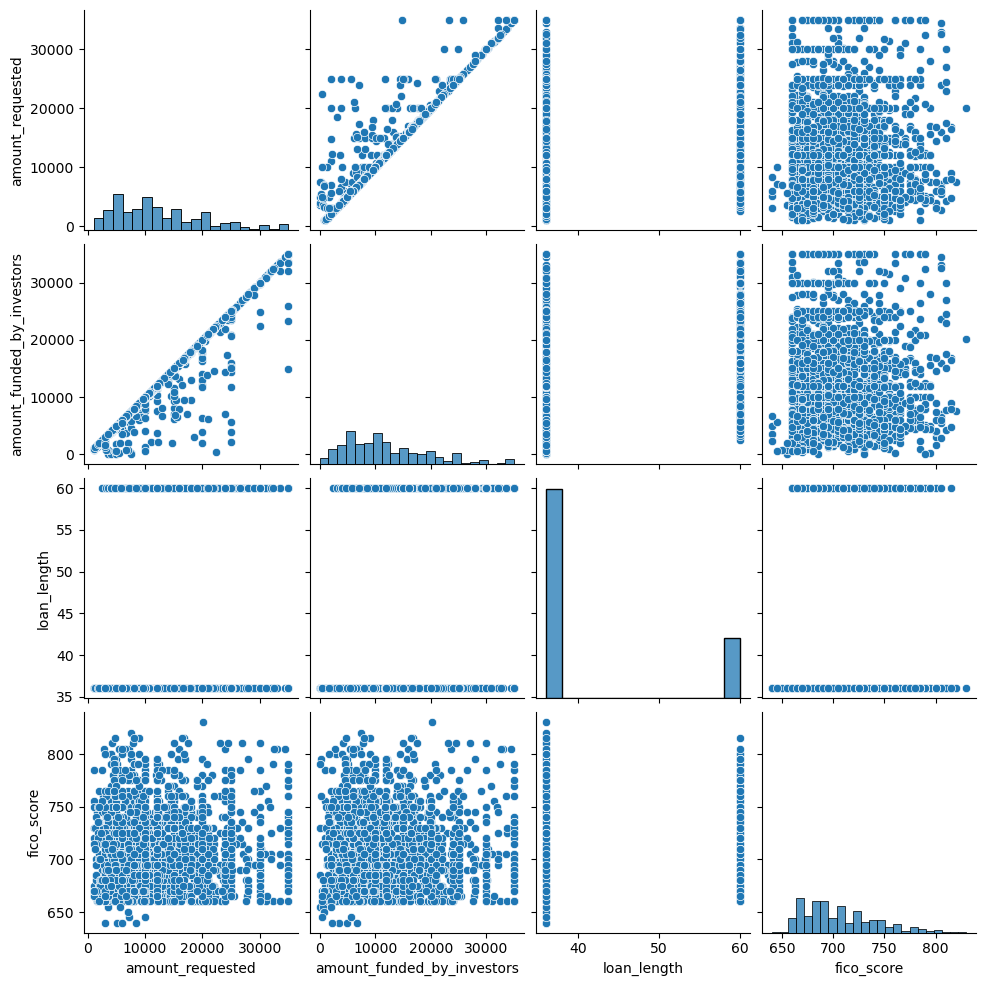

In [171]:
sns.pairplot(X_train)

In [172]:
# creating linear regression model 1 and printing summary info

y_hat = functions.linear_regression_model(X_train, y_train, X_test)
functions.model_summary(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              5707.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):                        0.00
Time:                        08:27:46   Log-Likelihood:                         -5549.8
No. Observations:                1998   AIC:                                  1.111e+04
Df Residuals:                    1994   BIC:                                  1.113e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.805e-05    4.7e-05     -0.384      0.701      -0.000     7.4e-05
x2             0.0001   4.72e-05      2.575      0.010     2.9e-05       0.000
x3             0.2120      0.009     22.760      0.000       0.194       0.230
x4             0.0041      0.001      7.989      0.000       0.003       0.005
==============================================================================
Omnibus:                       50.937   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.885
Skew:                           0.004   Prob(JB):                     2.39e-06
Kurtosis:                       2.442   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [173]:
# RMSE for model 1

functions.rmse(y_test, y_hat)

2.087972651105698

In [174]:
# RMSE of training and test set with K-folds for model 1

functions.cross_val_linear(X_train, y_train, 5)

(2.1088721411966143, 2.112034767050669)

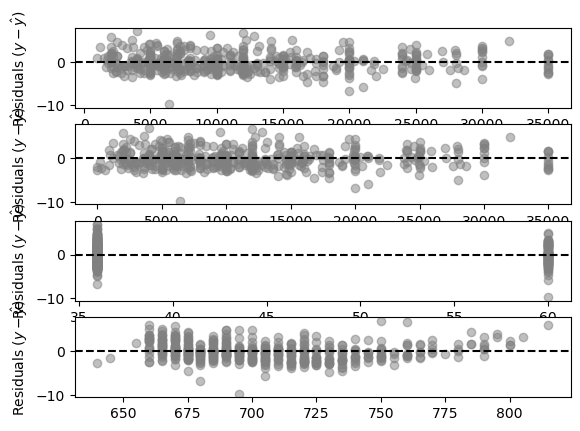

In [175]:
# Residual plot for each individual feature

fig, ax = plt.subplots(4,1)

for idx, val in enumerate(X_test.columns):
    functions.residual_plot(ax[idx], X_test[val], y_test, y_hat)

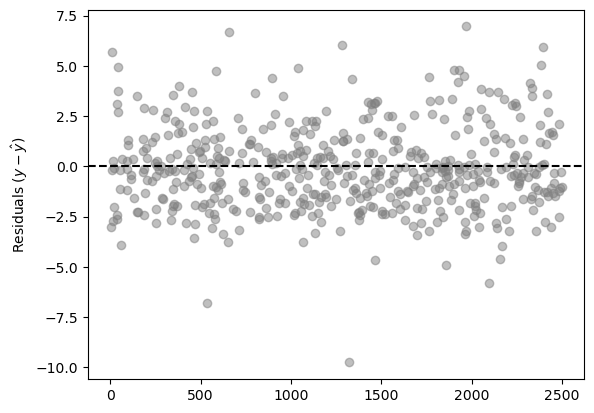

In [176]:
# Residual plot for entire model 1

fig, ax = plt.subplots()
functions.residual_plot(ax, X_test.index, y_test, y_hat)

In [177]:
# Model 2 Dataframe Creation

X2 = X[['amount_funded_by_investors', 'loan_length', 'fico_score']]
y2 = y
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

In [178]:
# creating linear regression model 2 and printing summary info

y2_hat = functions.linear_regression_model(X2_train, y2_train, X2_test)
functions.model_summary(y2_train, X2_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              7540.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):                        0.00
Time:                        08:27:47   Log-Likelihood:                         -5554.8
No. Observations:                1998   AIC:                                  1.112e+04
Df Residuals:                    1995   BIC:                                  1.113e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.925e-05   1.23e-05      8.038      0.000     7.5e-05       0.000
x2             0.2159      0.009     22.837      0.000       0.197       0.234
x3             0.0040      0.001      7.604      0.000       0.003       0.005
==============================================================================
Omnibus:                       65.489   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.638
Skew:                           0.002   Prob(JB):                     2.22e-07
Kurtosis:                       2.393   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [179]:
# RMSE for model 2

functions.rmse(y2_test, y2_hat)

2.3326329806264425

In [180]:
# RMSE of training and test set with K-folds for model 2

functions.cross_val_linear(X2_train, y2_train, 5)

(2.0480653000438336, 2.05268437716634)

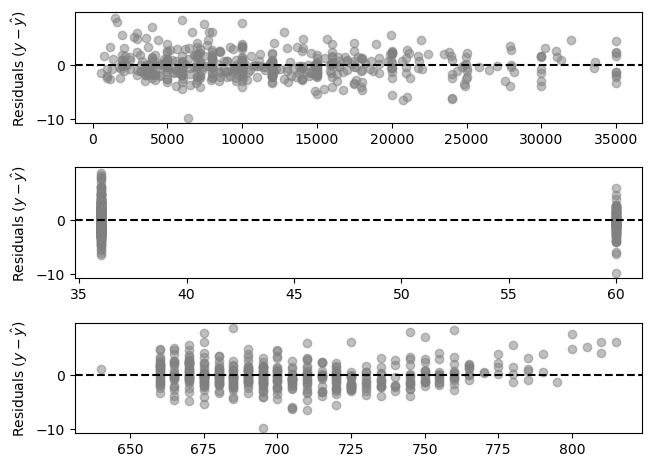

In [181]:
# Residual plot for each individual feature model 2

fig, ax = plt.subplots(3,1)
fig.tight_layout()

for idx, val in enumerate(X2_test.columns):
    functions.residual_plot(ax[idx], X2_test[val], y2_test, y2_hat)

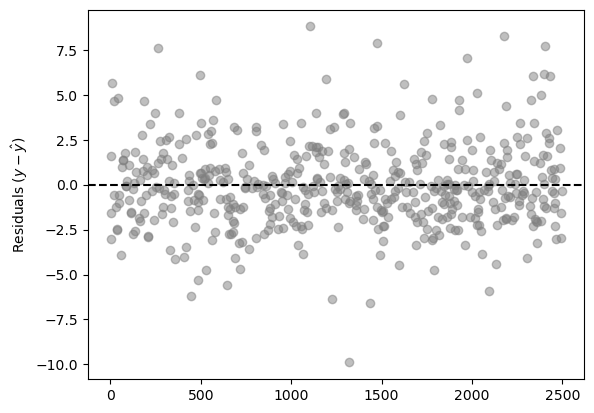

In [182]:
# Residual plot for entire model 2

fig, ax = plt.subplots()
functions.residual_plot(ax, X2_test.index, y2_test, y2_hat)

In [183]:
# Model 3 DataFrame Creation

X_train_norm, y_train_norm, X_test_norm, y_test_norm = functions.normalize_data(X, y)

In [184]:
# RMSE of training and test set using Ridge regression for model 2

functions.cross_val_ridge(X_train_norm, y_train_norm, 3, alpha=0.01)

(0.1069957504792638, 0.1075896151945148)

In [185]:
# training Ridge regression model at various alpha values to find minimum RMSE on test set

ridge_alphas = np.logspace(-2, 0.2, num=100)

ridge_cv_errors_train, ridge_cv_errors_test = functions.train_at_various_alphas(X_train_norm, y_train_norm, model=Ridge, alphas=ridge_alphas)
alpha_min = ridge_cv_errors_test.idxmin()

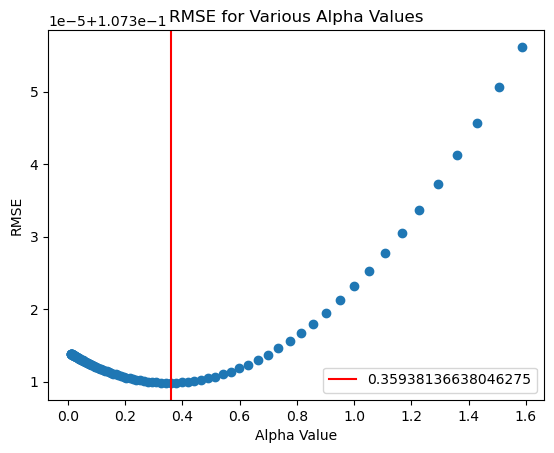

In [186]:
# plotting range of alpha values to find minimum RMSE

plt.scatter(ridge_cv_errors_test.index, ridge_cv_errors_test.values)
plt.axvline(ridge_cv_errors_test.idxmin(), color='r', label=ridge_cv_errors_test.idxmin())
# plt.ylim(0.10914,0.10920)
plt.title('RMSE for Various Alpha Values')
plt.xlabel('Alpha Value')
plt.ylabel('RMSE')
plt.legend()

In [187]:
model_1_linear_rmse = functions.rmse(y_test, y_hat)
model_1_cross_val_rmse = functions.cross_val_linear(X_train, y_train, 5)[1]

model_2_linear_rmse = functions.rmse(y2_test, y2_hat)
model_2_cross_val_rmse = functions.cross_val_linear(X2_train, y2_train, 5)[1]

model_3_ridge_rmse = functions.cross_val_ridge(X_train_norm, y_train_norm, 3, alpha=alpha_min)[1]

In [188]:
testing = pd.DataFrame([model_1_linear_rmse, model_1_cross_val_rmse, model_2_linear_rmse, model_2_linear_rmse, model_3_ridge_rmse])
testing.rename(index={0:'model_1_linear_rmse', 1:'model_1_cross_val_rmse', 2:'model_2_linear_rmse', 3:'model_2_cross_val_rmse', 4:'model_3_ridge_rmse'}, columns={0: 'RMSE'}, inplace=True)
testing

,RMSE
model_1_linear_rmse,2.087973
model_1_cross_val_rmse,2.112035
model_2_linear_rmse,2.332633
model_2_cross_val_rmse,2.332633
model_3_ridge_rmse,0.107581
